---
author: Zeel B Patel
badges: true
categories: ML
description: Pruning vs Uncertainty
title: Pruning vs Uncertainty
date: '2023-09-14'
toc: true
---

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn

# import pruning library
import torch.nn.utils.prune as prune

# import torchvision
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

try:
    from laplace import Laplace
except ModuleNotFoundError:
    %pip install laplace-torch
    from laplace import Laplace

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Train a model on MNIST

In [3]:
# Define data transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # convert dtype to float32
        # transforms.Lambda(lambda x: x.to(torch.float32)),
    ]
)


In [4]:
# Load MNIST dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
print("Train size", len(train_dataset))

train_dataset = TensorDataset(
    train_dataset.data[..., None]
    .repeat(1, 1, 1, 3)
    .swapaxes(1, 3)
    .swapaxes(2, 3)
    .to(torch.float32)
    .to(device),
    train_dataset.targets.to(device),
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)
print("Test size", len(test_dataset))
test_dataset = TensorDataset(
    test_dataset.data[..., None]
    .repeat(1, 1, 1, 3)
    .swapaxes(1, 3)
    .swapaxes(2, 3)
    .to(torch.float32)
    .to(device),
    test_dataset.targets.to(device),
)


Using cuda device
Train size 60000
Test size 10000


In [5]:
train_dataset[0][0].dtype, train_dataset[0][1].dtype


(torch.float32, torch.int64)

In [6]:
# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Load pre-trained ResNet model
resnet = torchvision.models.resnet18(pretrained=True)
print("Loaded pre-trained ResNet18 model")
print(resnet.fc.in_features)

# Modify the last fully connected layer to match MNIST's number of classes (10)
num_classes = 10
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
    nn.GELU(),
    nn.Linear(resnet.fc.in_features, num_classes),
)

# Freeze all layers except the last fully connected layer
for name, param in resnet.named_parameters():
    param.requires_grad = False
resnet.fc.requires_grad_(True)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
print(f"Training on device {device}")
resnet.to(device)

print("Training ResNet18 model")
for epoch in range(num_epochs):
    resnet.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

    # Evaluation
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        predicted_list = []
        for images, labels in test_loader:
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pre-trained ResNet18 model
512
Training on device cuda
Training ResNet18 model


100%|██████████| 938/938 [00:03<00:00, 242.75it/s]


Epoch [1/50] Loss: 1.0877
Accuracy on the test set: 75.42%


100%|██████████| 938/938 [00:03<00:00, 262.53it/s]


Epoch [2/50] Loss: 0.8051
Accuracy on the test set: 76.74%


100%|██████████| 938/938 [00:03<00:00, 270.43it/s]


Epoch [3/50] Loss: 0.7578
Accuracy on the test set: 78.27%


100%|██████████| 938/938 [00:03<00:00, 265.38it/s]


Epoch [4/50] Loss: 0.7290
Accuracy on the test set: 78.71%


100%|██████████| 938/938 [00:03<00:00, 265.51it/s]


Epoch [5/50] Loss: 0.7083
Accuracy on the test set: 79.62%


100%|██████████| 938/938 [00:03<00:00, 266.62it/s]


Epoch [6/50] Loss: 0.6761
Accuracy on the test set: 79.82%


100%|██████████| 938/938 [00:03<00:00, 268.49it/s]


Epoch [7/50] Loss: 0.6627
Accuracy on the test set: 80.47%


100%|██████████| 938/938 [00:03<00:00, 266.33it/s]


Epoch [8/50] Loss: 0.6423
Accuracy on the test set: 80.24%


100%|██████████| 938/938 [00:03<00:00, 268.52it/s]


Epoch [9/50] Loss: 0.6257
Accuracy on the test set: 81.11%


100%|██████████| 938/938 [00:03<00:00, 269.38it/s]


Epoch [10/50] Loss: 0.6131
Accuracy on the test set: 81.42%


100%|██████████| 938/938 [00:03<00:00, 264.77it/s]


Epoch [11/50] Loss: 0.5911
Accuracy on the test set: 82.02%


100%|██████████| 938/938 [00:03<00:00, 266.07it/s]


Epoch [12/50] Loss: 0.5765
Accuracy on the test set: 82.32%


100%|██████████| 938/938 [00:03<00:00, 262.19it/s]


Epoch [13/50] Loss: 0.5611
Accuracy on the test set: 82.30%


100%|██████████| 938/938 [00:04<00:00, 214.62it/s]


Epoch [14/50] Loss: 0.5466
Accuracy on the test set: 82.49%


100%|██████████| 938/938 [00:04<00:00, 219.31it/s]


Epoch [15/50] Loss: 0.5358
Accuracy on the test set: 82.81%


100%|██████████| 938/938 [00:04<00:00, 226.53it/s]


Epoch [16/50] Loss: 0.5266
Accuracy on the test set: 83.30%


100%|██████████| 938/938 [00:05<00:00, 171.25it/s]


Epoch [17/50] Loss: 0.5137
Accuracy on the test set: 83.37%


100%|██████████| 938/938 [00:03<00:00, 278.59it/s]


Epoch [18/50] Loss: 0.5051
Accuracy on the test set: 83.17%


100%|██████████| 938/938 [00:03<00:00, 248.82it/s]


Epoch [19/50] Loss: 0.4969
Accuracy on the test set: 83.46%


100%|██████████| 938/938 [00:05<00:00, 175.56it/s]


Epoch [20/50] Loss: 0.4811
Accuracy on the test set: 83.76%


100%|██████████| 938/938 [00:03<00:00, 277.18it/s]


Epoch [21/50] Loss: 0.4714
Accuracy on the test set: 83.57%


100%|██████████| 938/938 [00:03<00:00, 273.71it/s]


Epoch [22/50] Loss: 0.4624
Accuracy on the test set: 84.25%


100%|██████████| 938/938 [00:03<00:00, 242.18it/s]


Epoch [23/50] Loss: 0.4553
Accuracy on the test set: 84.27%


100%|██████████| 938/938 [00:03<00:00, 279.42it/s]


Epoch [24/50] Loss: 0.4506
Accuracy on the test set: 84.62%


100%|██████████| 938/938 [00:03<00:00, 269.21it/s]


Epoch [25/50] Loss: 0.4394
Accuracy on the test set: 83.97%


100%|██████████| 938/938 [00:04<00:00, 227.36it/s]


Epoch [26/50] Loss: 0.4346
Accuracy on the test set: 84.16%


100%|██████████| 938/938 [00:04<00:00, 222.91it/s]


Epoch [27/50] Loss: 0.4271
Accuracy on the test set: 84.38%


100%|██████████| 938/938 [00:04<00:00, 223.68it/s]


Epoch [28/50] Loss: 0.4193
Accuracy on the test set: 84.84%


100%|██████████| 938/938 [00:03<00:00, 261.50it/s]


Epoch [29/50] Loss: 0.4148
Accuracy on the test set: 85.05%


100%|██████████| 938/938 [00:03<00:00, 246.52it/s]


Epoch [30/50] Loss: 0.4040
Accuracy on the test set: 84.49%


100%|██████████| 938/938 [00:03<00:00, 281.60it/s]


Epoch [31/50] Loss: 0.3990
Accuracy on the test set: 84.59%


100%|██████████| 938/938 [00:03<00:00, 278.41it/s]


Epoch [32/50] Loss: 0.4016
Accuracy on the test set: 84.92%


100%|██████████| 938/938 [00:03<00:00, 275.60it/s]


Epoch [33/50] Loss: 0.3979
Accuracy on the test set: 85.01%


100%|██████████| 938/938 [00:03<00:00, 250.04it/s]


Epoch [34/50] Loss: 0.3844
Accuracy on the test set: 84.82%


100%|██████████| 938/938 [00:03<00:00, 280.53it/s]


Epoch [35/50] Loss: 0.3789
Accuracy on the test set: 85.49%


100%|██████████| 938/938 [00:03<00:00, 279.26it/s]


Epoch [36/50] Loss: 0.3760
Accuracy on the test set: 85.26%


100%|██████████| 938/938 [00:04<00:00, 207.71it/s]


Epoch [37/50] Loss: 0.3733
Accuracy on the test set: 85.36%


100%|██████████| 938/938 [00:03<00:00, 265.92it/s]


Epoch [38/50] Loss: 0.3655
Accuracy on the test set: 84.98%


100%|██████████| 938/938 [00:03<00:00, 279.79it/s]


Epoch [39/50] Loss: 0.3627
Accuracy on the test set: 85.19%


100%|██████████| 938/938 [00:03<00:00, 276.73it/s]


Epoch [40/50] Loss: 0.3517
Accuracy on the test set: 84.78%


100%|██████████| 938/938 [00:03<00:00, 278.32it/s]


Epoch [41/50] Loss: 0.3526
Accuracy on the test set: 85.43%


100%|██████████| 938/938 [00:03<00:00, 243.70it/s]


Epoch [42/50] Loss: 0.3523
Accuracy on the test set: 85.55%


100%|██████████| 938/938 [00:03<00:00, 240.48it/s]


Epoch [43/50] Loss: 0.3457
Accuracy on the test set: 85.02%


100%|██████████| 938/938 [00:03<00:00, 274.70it/s]


Epoch [44/50] Loss: 0.3447
Accuracy on the test set: 85.20%


100%|██████████| 938/938 [00:03<00:00, 276.08it/s]


Epoch [45/50] Loss: 0.3411
Accuracy on the test set: 85.47%


100%|██████████| 938/938 [00:04<00:00, 215.18it/s]


Epoch [46/50] Loss: 0.3312
Accuracy on the test set: 85.55%


100%|██████████| 938/938 [00:03<00:00, 244.20it/s]


Epoch [47/50] Loss: 0.3290
Accuracy on the test set: 85.52%


100%|██████████| 938/938 [00:03<00:00, 267.56it/s]


Epoch [48/50] Loss: 0.3277
Accuracy on the test set: 85.35%


100%|██████████| 938/938 [00:03<00:00, 267.91it/s]


Epoch [49/50] Loss: 0.3241
Accuracy on the test set: 85.80%


100%|██████████| 938/938 [00:03<00:00, 266.04it/s]


Epoch [50/50] Loss: 0.3217
Accuracy on the test set: 84.93%


In [11]:
# Evaluation
resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    predicted_list = []
    for images, labels in test_loader:
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        softmax_outputs = nn.Softmax(dim=1)(outputs)
        predicted_list.append(softmax_outputs.data.cpu().numpy())

all_predicted = np.concatenate(predicted_list, axis=0)
print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")


Accuracy on the test set: 84.93%


## Check calibration

In [12]:
test_dataset.tensors[1].cpu().numpy().shape, all_predicted.shape

((10000,), (10000, 10))

0.021885250088572478

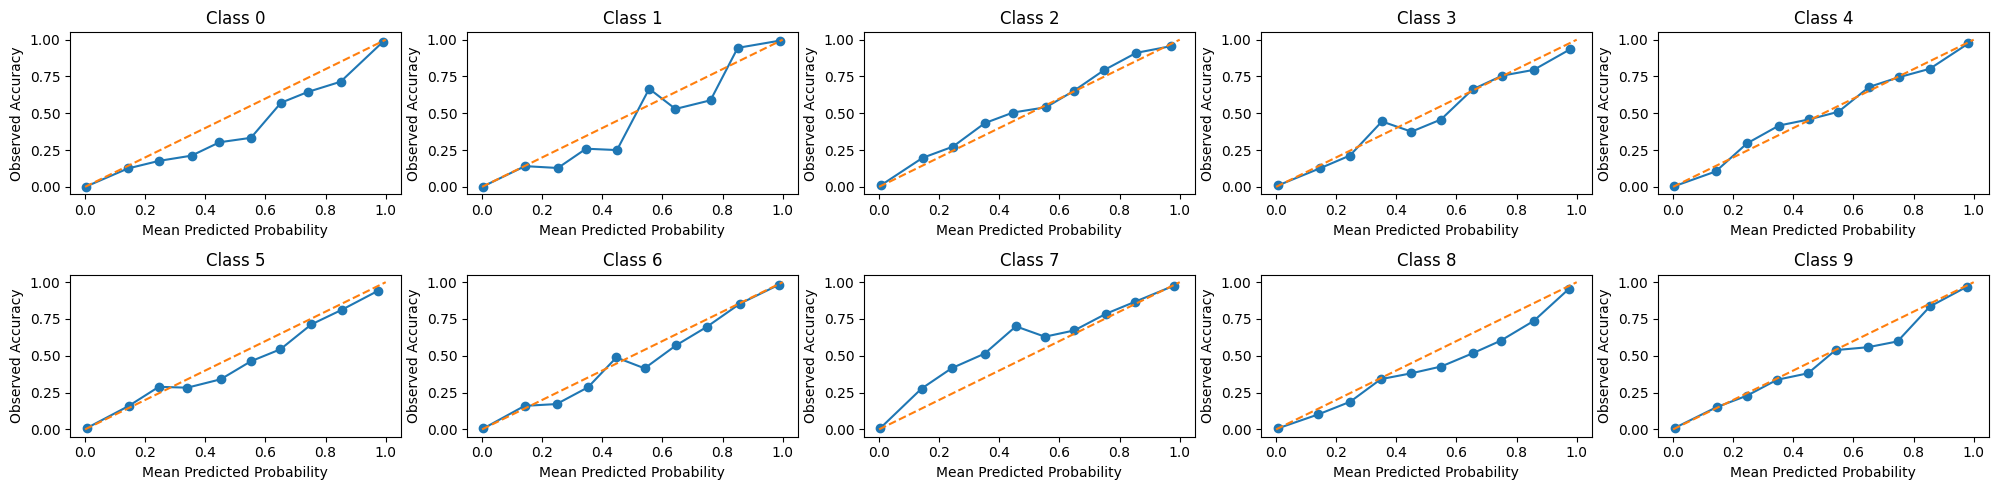

In [15]:
# Compute calibration curve

fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.flatten()

for target_class in range(10):
    true_labels = test_dataset.tensors[1].cpu().numpy() == target_class
    predicted_probabilities = all_predicted[:, target_class]

    prob_true, prob_pred = calibration_curve(
        true_labels, predicted_probabilities, n_bins=10
    )

    # Plot calibration curve
    axes[target_class].plot(prob_pred, prob_true, marker="o", label="Calibration Curve")
    axes[target_class].plot(
        [0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated"
    )
    axes[target_class].set_xlabel("Mean Predicted Probability")
    axes[target_class].set_ylabel("Observed Accuracy")
    # ece_score = compute_ece(predicted_probabilities, true_labels, num_bins=10)
    # print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

    axes[target_class].set_title(f"Class {target_class}")
plt.tight_layout()

# Compute expected calibration error (ECE)
ece = compute_ece(all_predicted, test_dataset.tensors[1].cpu().numpy(), 10)
ece


In [104]:
print(
    classification_report(
        test_dataset.tensors[1].cpu().numpy(), all_predicted.argmax(axis=1)
    )
)


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       980
           1       0.91      0.97      0.94      1135
           2       0.75      0.72      0.73      1032
           3       0.77      0.74      0.75      1010
           4       0.82      0.88      0.85       982
           5       0.68      0.70      0.69       892
           6       0.85      0.84      0.85       958
           7       0.80      0.79      0.79      1028
           8       0.76      0.75      0.75       974
           9       0.81      0.74      0.77      1009

    accuracy                           0.81     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.81      0.80     10000



In [14]:
def compute_ece(predicted_probs, true_labels, num_bins=10):
    # Ensure predicted_probs is a NumPy array
    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)

    # Calculate predicted class labels
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Calculate confidence scores (maximum predicted probability)
    confidence_scores = np.max(predicted_probs, axis=1)

    # Create bins for confidence scores
    bin_edges = np.linspace(0, 1, num_bins + 1)

    ece = 0.0
    total_samples = len(true_labels)

    for bin_idx in range(num_bins):
        # Find examples whose confidence scores fall into the current bin
        bin_mask = (confidence_scores >= bin_edges[bin_idx]) & (
            confidence_scores < bin_edges[bin_idx + 1]
        )

        if np.any(bin_mask):
            # Calculate the accuracy of predictions in this bin
            bin_accuracy = np.mean(predicted_labels[bin_mask] == true_labels[bin_mask])

            # Calculate the fraction of examples in this bin
            bin_fraction = np.sum(bin_mask) / total_samples

            # Calculate the calibration error in this bin
            bin_error = np.abs(bin_accuracy - np.mean(confidence_scores[bin_mask]))

            # Weighted contribution to ECE
            ece += bin_fraction * bin_error

    return ece

## Does MC-dropout help with calibration?

## Last layer only

In [111]:
class MCDropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.dropout = nn.Dropout(p=self.p)

    def forward(self, x):
        self.train()
        return self.dropout(x)


resnet_with_dropout = torchvision.models.resnet18(pretrained=True)
resnet_with_dropout.fc = nn.Sequential(
    nn.Linear(
        resnet_with_dropout.fc.in_features, resnet_with_dropout.fc.in_features // 2
    ),
    nn.GELU(),
    MCDropout(p=0.33),
    nn.Linear(resnet_with_dropout.fc.in_features // 2, num_classes),
)

resnet_with_dropout.load_state_dict(resnet.state_dict())

resnet_with_dropout.to(device)

mc_samples = 1000

outputs = []
for _ in tqdm(range(mc_samples)):
    output = resnet_with_dropout(test_dataset.tensors[0])
    softmax_output = nn.Softmax(dim=1)(output)
    outputs.append(softmax_output.data.cpu().numpy())

100%|██████████| 1000/1000 [00:18<00:00, 55.50it/s]


In [112]:
mc_mean = np.mean(outputs, axis=0)
mc_std = np.std(outputs, axis=0)
mc_mean.shape


(10000, 10)

0.04250686831623317

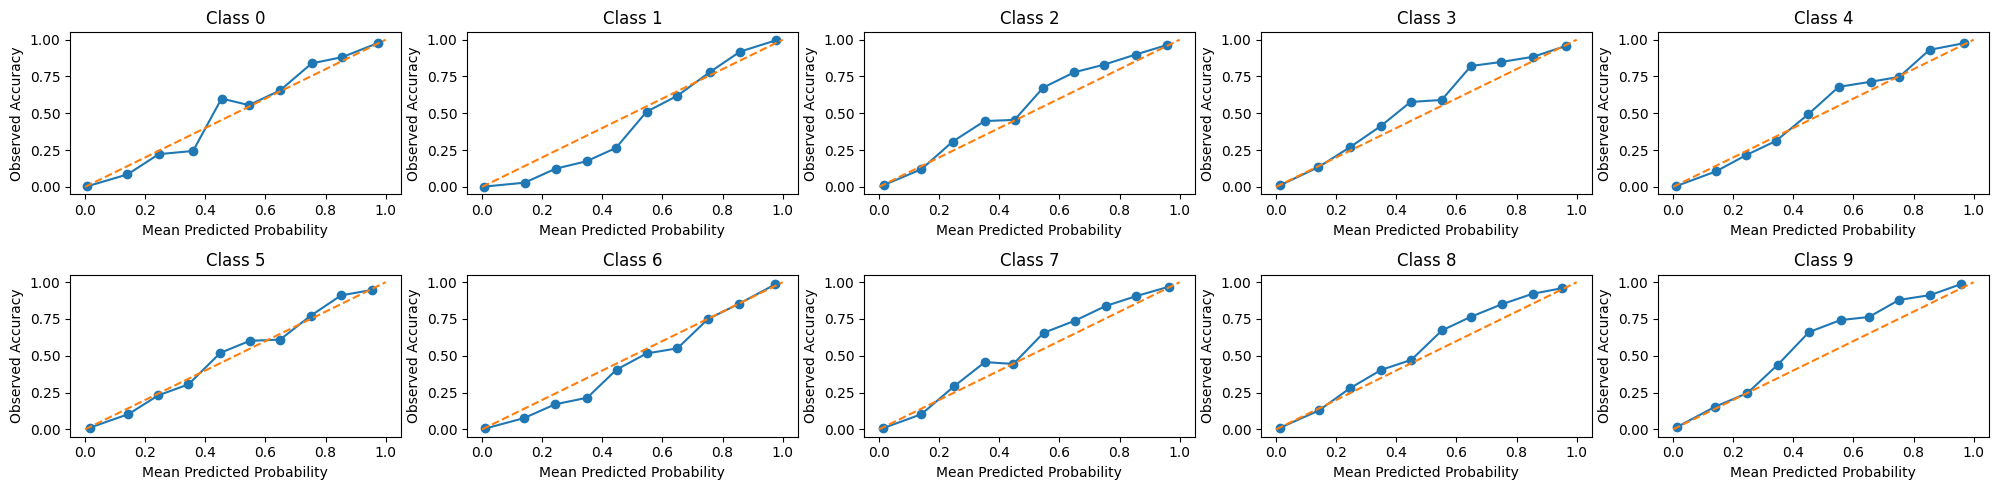

In [113]:
# Compute calibration curve

fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.flatten()

for target_class in range(10):
    true_labels = test_dataset.tensors[1].cpu().numpy() == target_class
    predicted_probabilities = mc_mean[:, target_class]

    prob_true, prob_pred = calibration_curve(
        true_labels, predicted_probabilities, n_bins=10
    )

    # Plot calibration curve
    axes[target_class].plot(prob_pred, prob_true, marker="o", label="Calibration Curve")
    axes[target_class].plot(
        [0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated"
    )
    axes[target_class].set_xlabel("Mean Predicted Probability")
    axes[target_class].set_ylabel("Observed Accuracy")
    axes[target_class].set_title(f"Class {target_class}")
plt.tight_layout()

ece = compute_ece(mc_mean, test_dataset.tensors[1].cpu().numpy(), 10)
ece


In [114]:
print(
    classification_report(test_dataset.tensors[1].cpu().numpy(), mc_mean.argmax(axis=1))
)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       980
           1       0.91      0.98      0.94      1135
           2       0.73      0.71      0.72      1032
           3       0.78      0.72      0.75      1010
           4       0.83      0.87      0.85       982
           5       0.68      0.71      0.69       892
           6       0.82      0.88      0.85       958
           7       0.80      0.78      0.79      1028
           8       0.77      0.74      0.75       974
           9       0.82      0.72      0.77      1009

    accuracy                           0.81     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.81      0.80     10000

